In [133]:
# Install necessary libraries
import json
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import color_conversion

## In this file, I have tried different methods to correct in RGB space.
## Method 0: Fixed White Scaling
## Method 1: Using Polynomial Correction
## Method 2: Using a 3 x 3 Matrix
## Method 3: Using multiple inputs (adding pitch & roll).


In [134]:
# Read json file
def readJsonData(JSON_FILE_PATH):
  data = None
  try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

  except FileNotFoundError:
      print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
      print("Please check the file path and ensure Google Drive is correctly mounted.")
  except json.JSONDecodeError:
      print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")
  return data

# Preprocessing
def preprocessData(data):
  flat_data = []

  # Extract metadata for easy merging later
  session_metadata = data.get('metadata', {})
  session_name = session_metadata.get('sessionName', 'Unknown Session')

  # Iterate through each sample (color card)
  for sample in data.get('data', []):
      sample_number = sample.get('sampleNumber')

      # Iterate through each measurement (1 to 10) within that sample
      for capture_index, measurement in enumerate(sample.get('measurements', [])):

          # Create a dictionary for the current row
          row = {
              'session_name': session_name,
              'sample_number': sample_number,
              'capture_index': capture_index, # 0 to 9
              'lighting_condition': session_metadata.get('lightingCondition'),
              'reflective_surface': session_metadata.get('useReflectiveSurface'),

              # Sensor Data
              'pitch': measurement['angles']['pitch'],
              'roll': measurement['angles']['roll'],
          }

          # Extract Color Data (White and Color reticles, three radii each)

          # White Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'white_r{radius}_R'] = color_data['r']
              row[f'white_r{radius}_G'] = color_data['g']
              row[f'white_r{radius}_B'] = color_data['b']

          # Color Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'color_r{radius}_R'] = color_data['r']
              row[f'color_r{radius}_G'] = color_data['g']
              row[f'color_r{radius}_B'] = color_data['b']

          flat_data.append(row)

  # Convert the list of dictionaries to a Pandas DataFrame
  df = pd.DataFrame(flat_data)

  print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")
  return df

# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.
def displayDataFrameInfo(df):
  print("\n--- DataFrame Head (First 5 Rows) ---")
  print(df.head())

  print("\n--- DataFrame Information ---")
  print(df.info())

  # ### 3.1 Check Sensor Variability

  # This checks the pitch/roll stability across all 240 measurements.
  print("\n--- Sensor Angle Statistics ---")
  print(df[['pitch', 'roll']].describe())

def merge_datasets_for_model(dfs):
    """
    Vertically concatenate multiple datasets.
    All rows are kept. Column names must be consistent.

    Parameters
    ----------
    dfs : list of pd.DataFrame
        List of datasets with identical column structure

    Returns
    -------
    pd.DataFrame
        Combined dataset
    """
    merged_df = pd.concat(dfs, axis=0, ignore_index=True)
    return merged_df


In [135]:
def combineGroundTruth(df):
  ground_truth_data = [
      {'sample_number': 1,  'label': 'Dark Skin',      'gt__R': 115, 'gt__G': 82,  'gt__B': 69},
      {'sample_number': 2,  'label': 'Light Skin',     'gt__R': 204, 'gt__G': 161, 'gt__B': 141},
      {'sample_number': 3,  'label': 'Blue Sky',       'gt__R': 101, 'gt__G': 134, 'gt__B': 179},
      {'sample_number': 4,  'label': 'Foliage',        'gt__R': 89,  'gt__G': 109, 'gt__B': 61},
      {'sample_number': 5,  'label': 'Blue Flower',    'gt__R': 141, 'gt__G': 137, 'gt__B': 194},
      {'sample_number': 6,  'label': 'Bluish Green',   'gt__R': 132, 'gt__G': 228, 'gt__B': 208},
      {'sample_number': 7,  'label': 'Orange',         'gt__R': 249, 'gt__G': 118, 'gt__B': 35},
      {'sample_number': 8,  'label': 'Purplish Blue',  'gt__R': 80,  'gt__G': 91,  'gt__B': 182},
      {'sample_number': 9,  'label': 'Moderate Red',   'gt__R': 222, 'gt__G': 91,  'gt__B': 125},
      {'sample_number': 10, 'label': 'Purple',         'gt__R': 91,  'gt__G': 63,  'gt__B': 123},
      {'sample_number': 11, 'label': 'Yellow Green',   'gt__R': 173, 'gt__G': 232, 'gt__B': 91},
      {'sample_number': 12, 'label': 'Orange Yellow',  'gt__R': 255, 'gt__G': 164, 'gt__B': 26},
      {'sample_number': 13, 'label': 'Blue',           'gt__R': 44,  'gt__G': 56,  'gt__B': 142},
      {'sample_number': 14, 'label': 'Green',          'gt__R': 74,  'gt__G': 148, 'gt__B': 81},
      {'sample_number': 15, 'label': 'Red',            'gt__R': 179, 'gt__G': 42,  'gt__B': 50},
      {'sample_number': 16, 'label': 'Yellow',         'gt__R': 250, 'gt__G': 226, 'gt__B': 21},
      {'sample_number': 17, 'label': 'Magenta',        'gt__R': 191, 'gt__G': 81,  'gt__B': 160},
      {'sample_number': 18, 'label': 'Cyan',           'gt__R': 6,   'gt__G': 142, 'gt__B': 172},
      {'sample_number': 19, 'label': 'White',          'gt__R': 252, 'gt__G': 252, 'gt__B': 252},
      {'sample_number': 20, 'label': 'Neutral 8',      'gt__R': 230, 'gt__G': 230, 'gt__B': 230},
      {'sample_number': 21, 'label': 'Neutral 6.5',    'gt__R': 200, 'gt__G': 200, 'gt__B': 200},
      {'sample_number': 22, 'label': 'Neutral 5',      'gt__R': 143, 'gt__G': 143, 'gt__B': 142},
      {'sample_number': 23, 'label': 'Neutral 3.5',    'gt__R': 100, 'gt__G': 100, 'gt__B': 100},
      {'sample_number': 24, 'label': 'Black',          'gt__R': 50,  'gt__G': 50,  'gt__B': 50},
  ]
  df_gt = pd.DataFrame(ground_truth_data)
  df = pd.merge(df, df_gt, on='sample_number', how='outer')

  return df, df_gt

def generateFinalDataFrame(df_with_gt_columns):
  # Calculate average color and corrected color values per sample_number
  avg_cols_to_compute = [
      'color_r0_R', 'color_r0_G', 'color_r0_B',
      'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
      'color_r2_R', 'color_r2_G', 'color_r2_B',
      'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
      'color_r4_R', 'color_r4_G', 'color_r4_B',
      'correction_r4_R', 'correction_r4_G', 'correction_r4_B'
  ]
  df_avg = df_with_gt_columns.groupby('sample_number')[avg_cols_to_compute].mean().reset_index()

  # Rename columns to 'avg_...' to clearly distinguish them
  new_avg_columns_map = {col: 'avg_' + col for col in avg_cols_to_compute}
  df_avg = df_avg.rename(columns=new_avg_columns_map)

  # Merge the df (which now has ground truth) with the averaged color data
  df_final_comparison = pd.merge(df_with_gt_columns, df_avg, on='sample_number', how='left')

  return df_final_comparison

In [136]:
jsonFilePath = 'Data/Baisu1.json'
data = readJsonData(jsonFilePath)
df = preprocessData(data)
df, _ = combineGroundTruth(df)

✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : baisu1
lightingCondition   : 0
useReflectiveSurface: False
dateTime            : 2025-11-19T15:01:46.558942

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).


## Method 1: Using Polynomial Correction:  
1. correction_r2_H = f1(color_r2_H)
2. correction_r2_S = f2(color_r2_S)
3. correction_r2_V = f3(color_r2_V).
## Our task: Learn the degrees and coefficients of f1, f2, f3.
## Conclusion: Compare with Fixed Scaling Method

In [137]:
def correctByPolynomial_optimizable(meas_h, meas_s, meas_v, coeffs_h, coeffs_s, coeffs_v):
    """Apply polynomials without clipping for optimization"""
    corr_h = np.polyval(coeffs_h[::-1], meas_h) if len(coeffs_h) > 0 else meas_h
    corr_s = np.polyval(coeffs_s[::-1], meas_s) if len(coeffs_s) > 0 else meas_s
    corr_v = np.polyval(coeffs_v[::-1], meas_v) if len(coeffs_v) > 0 else meas_v
    return corr_h, corr_s, corr_v

def calculateSingleChannelLoss(coeffs, measured_values, gt_values, degree):
    def _apply_single_channel_polynomial(meas, ch_coeffs):
        return np.polyval(ch_coeffs[::-1], meas)

    corrected_values = _apply_single_channel_polynomial(measured_values, coeffs)
    # Calculate MSE
    mse = mean_squared_error(gt_values, corrected_values)
    # Add boundary penalty
    # boundary_penalty = np.mean((corrected_values < 5) | (corrected_values > 250)) * 1000
    # Add coefficient penalty
    coeff_penalty = 0.001 * np.sum(coeffs**2)

    return mse + coeff_penalty

def get_smart_initial_guess_single_channel(measured_series, gt_series, degree):
    """Get reasonable initial coefficients for a single channel using linear regression"""
    X = measured_series.values
    y = gt_series.values

    try:
        if degree == 0:
            coeffs = [np.mean(y)]
        else:
            # Polynomial fit (coeffs are in decreasing order of power)
            poly_coeffs = np.polyfit(X, y, degree)
            coeffs = poly_coeffs[::-1].tolist()  # Convert to our format (lowest degree first)
    except Exception:
        # Fallback: identity mapping coefficients or mean if fit fails
        if degree == 0:
            coeffs = [np.mean(y)]  # Use mean if it fails for degree 0
        elif degree == 1:
            coeffs = [0.0, 1.0]  # Identity: y = x (c0=0, c1=1)
        else:
            coeffs = [0.0] * (degree + 1)
            if degree >= 1: # Set linear term to 1 for higher degrees as a starting point
                coeffs[1] = 1.0
    return np.array(coeffs)

def get_smart_initial_guess(df, degrees):
    """Get reasonable initial coefficients using linear regression"""
    initial_guess = []

    for channel, degree in degrees.items():
        X = df[f'color_r4_{channel}'].values
        y = df[f'gt__{channel}'].values

        # Use polyfit to get reasonable starting point
        try:
            if degree == 0:
                coeffs = [np.mean(y)]
            else:
                poly_coeffs = np.polyfit(X, y, degree)
                coeffs = poly_coeffs[::-1].tolist()  # Convert to our format (lowest degree first)
        except:
            if degree == 0:
                coeffs = [128.0]  # Middle value
            elif degree == 1:
                coeffs = [0.0, 1.0]  # Identity: y = x
            else:
                coeffs = [0.0] * (degree + 1)
                coeffs[1] = 1.0  # Linear term = 1

        initial_guess.extend(coeffs)

    return np.array(initial_guess)

def optimizeSingleChannelCoefficients(df, channel, degree):
    """Optimize coefficients for a single channel"""
    print(f"Optimizing polynomial for {channel} channel with degree {degree}")

    measured_values = df[f'color_r4_{channel}'].values
    gt_values = df[f'gt__{channel}'].values

    # Get smart initial guess
    initial_guess = get_smart_initial_guess_single_channel(df[f'color_r4_{channel}'], df[f'gt__{channel}'], degree)
    print(f"Initial guess for {channel}: {initial_guess}")

    # Define bounds for coefficients
    bounds = [(-1000, 1000)] * (degree + 1)

    # Use a partial function to pass fixed arguments to the loss function
    loss_func = partial(calculateSingleChannelLoss, measured_values=measured_values, gt_values=gt_values, degree=degree)

    # Optimize
    result = minimize(
        loss_func,
        initial_guess,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 1000, 'ftol': 1e-8}
    )

    optimal_coeffs = result.x

    dummy_meas = np.zeros_like(measured_values)

    if channel == 'H':
        final_corr_h, _, _ = correctByPolynomial_optimizable(measured_values, dummy_meas, dummy_meas, optimal_coeffs, np.array([0.0]), np.array([0.0]))
        final_corrected_values = final_corr_h % 1.0  # Wrap H values
    elif channel == 'S':
        _, final_corr_s, _ = correctByPolynomial_optimizable(dummy_meas, measured_values, dummy_meas, np.array([0.0]), optimal_coeffs, np.array([0.0]))
        final_corrected_values = np.clip(final_corr_s, 0, 1)
    elif channel == 'V':
        _, _, final_corr_v = correctByPolynomial_optimizable(dummy_meas, dummy_meas, measured_values, np.array([0.0]), np.array([0.0]), optimal_coeffs)
        final_corrected_values = np.clip(final_corr_v, 0, 1)
    else:
        raise ValueError("Invalid channel")

    final_mse = mean_squared_error(gt_values, final_corrected_values)

    print(f"Final MSE for {channel}: {final_mse:.2f}")
    print(f"{channel} coefficients: {optimal_coeffs}")
    print(f"Value ranges - {channel}: [{final_corrected_values.min()}, {final_corrected_values.max()}]")

    return {
        'coeffs': optimal_coeffs.tolist(),
        'mse': final_mse
    }

def calculateUnifiedLoss(all_coeffs, df, degrees):
    """
    Calculate loss for all channels simultaneously
    with penalty for boundary solutions
    """
    # Split coefficients for each channel
    n_h = degrees['H'] + 1
    n_s = degrees['S'] + 1
    n_v = degrees['V'] + 1

    coeffs_h = all_coeffs[:n_h]
    coeffs_s = all_coeffs[n_h:n_h+n_s]
    coeffs_v = all_coeffs[n_h+n_s:]

    # Get corrected values
    corr_h, corr_s, corr_v = correctByPolynomial_optimizable(
        df['color_r4_H'].values,
        df['color_r4_S'].values,
        df['color_r4_V'].values,
        coeffs_h, coeffs_s, coeffs_v
    )

    # Calculate MSE for each channel
    mse_h = mean_squared_error(df['gt__H'].values, corr_h)
    mse_s = mean_squared_error(df['gt__S'].values, corr_s)
    mse_v = mean_squared_error(df['gt__V'].values, corr_v)

    # Total MSE (weighted equally)
    total_mse = (mse_h + mse_s + mse_v) / 3.0

    # **CRITICAL: Add penalty for boundary solutions**
    boundary_penalty = 0.0

    # Penalize values near 0 or 1
    penalty_s = np.mean((corr_s < 0.01) | (corr_s > 0.99)) * 1000
    penalty_v = np.mean((corr_v < 0.01) | (corr_v > 0.99)) * 1000

    boundary_penalty = penalty_s + penalty_v
    # Penalize extreme coefficients to prevent overfitting
    coeff_penalty = 0.001 * (np.sum(coeffs_h**2) + np.sum(coeffs_s**2) + np.sum(coeffs_v**2))

    return total_mse + boundary_penalty + coeff_penalty

def optimizeUnifiedCoefficients(df, degrees):
    """Optimize all channels together with the same degree"""
    print(f"Optimizing unified polynomials with degrees H:{degrees['H']}, S:{degrees['S']}, V:{degrees['V']}")

    # Get smart initial guess
    initial_guess = get_smart_initial_guess(df, degrees)

    print(f"Initial guess: {initial_guess}")

    # Define bounds to prevent extreme coefficients
    bounds = []
    total_coeffs = (degrees['H'] + 1) + (degrees['S'] + 1) + (degrees['V'] + 1)
    # Reasonable bounds for coefficients
    for i in range(total_coeffs):
        # Allow some flexibility but prevent extreme values
        bounds.append((-1000, 1000))

    # Optimize with constraints
    result = minimize(
        calculateUnifiedLoss,
        initial_guess,
        args=(df, degrees),
        method='L-BFGS-B',  # Handles bounds
        bounds=bounds,
        options={'maxiter': 1000, 'ftol': 1e-8}
    )

    # Split the optimized coefficients
    n_h = degrees['H'] + 1
    n_s = degrees['S'] + 1
    n_v = degrees['V'] + 1

    optimal_coeffs_h = result.x[:n_h]
    optimal_coeffs_s = result.x[n_h:n_h+n_s]
    optimal_coeffs_v = result.x[n_h+n_s:]

    # Calculate final performance
    final_h, final_s, final_v = correctByPolynomial_optimizable(
        df['color_r4_H'].values,
        df['color_r4_S'].values,
        df['color_r4_V'].values,
        optimal_coeffs_h, optimal_coeffs_s, optimal_coeffs_v
    )

    # Apply clipping only for final output
    final_h = final_h % 1.0  # Wrap H values
    final_s = np.clip(final_s, 0, 1)
    final_v = np.clip(final_v, 0, 1)

    mse_h = mean_squared_error(df['gt__H'].values, final_h)
    mse_s = mean_squared_error(df['gt__S'].values, final_s)
    mse_v = mean_squared_error(df['gt__V'].values, final_v)
    avg_mse = (mse_h + mse_s + mse_v) / 3.0

    print(f"Final MSE - H: {mse_h:.2f}, S: {mse_s:.2f}, V: {mse_v:.2f}, Avg: {avg_mse:.2f}")
    print(f"H coefficients: {optimal_coeffs_h}")
    print(f"S coefficients: {optimal_coeffs_s}")
    print(f"V coefficients: {optimal_coeffs_v}")

    # Check value ranges
    print(f"Value ranges - H: [{final_h.min()}, {final_h.max()}], S: [{final_s.min()}, {final_s.max()}], V: [{final_v.min()}, {final_v.max()}]")

    return {
        'H': optimal_coeffs_h.tolist(),
        'S': optimal_coeffs_s.tolist(),
        'V': optimal_coeffs_v.tolist(),
        'mse': avg_mse,
        'mse_h': mse_h,
        'mse_s': mse_s,
        'mse_v': mse_v
    }

In [138]:
def findBestPolynomials_individual(df, max_degree=10):
    """
    Find the best polynomial degrees for each channel individually
    Only tests max_degree combinations per channel (30 total for max_degree=10)
    """
    print(f"Optimizing channels individually (max {max_degree} degrees per channel)")

    best_results = {}
    best_degrees = {}

    # Optimize each channel separately
    for channel in ['H', 'S', 'V']:
        print(f"\n{'='*50}")
        print(f"OPTIMIZING CHANNEL {channel}")
        print(f"{'='*50}")

        channel_best_result = None
        channel_best_degree = None

        # Try different degrees for this channel only
        for degree in range(1, max_degree + 1):
            print(f"\nTesting degree {degree} for channel {channel}")

            try:
                # Use your original single-channel optimization
                result = optimizeSingleChannel(df, channel, degree)

                if channel_best_result is None or result['mse'] < channel_best_result['mse']:
                    channel_best_result = result
                    channel_best_degree = degree
                    print(f"*** NEW BEST for {channel}: MSE = {result['mse']:.4f} at degree {degree} ***")
                else:
                    print(f"No improvement. Current best MSE: {channel_best_result['mse']:.4f}")

            except Exception as e:
                print(f"Failed for {channel} degree {degree}: {e}")
                continue

        # Store the best result for this channel
        best_results[channel] = channel_best_result
        best_degrees[channel] = channel_best_degree

        print(f"\n--- BEST RESULT FOR CHANNEL {channel} ---")
        print(f"Best degree: {channel_best_degree}")
        print(f"Best MSE: {channel_best_result['mse']:.4f}")
        print(f"Best coefficients: {channel_best_result['coefficients']}")

    # Combine results
    final_result = {
        'H': best_results['H']['coefficients'],
        'S': best_results['S']['coefficients'],
        'V': best_results['V']['coefficients'],
        'mse_h': best_results['H']['mse'],
        'mse_s': best_results['S']['mse'],
        'mse_v': best_results['V']['mse'],
        'avg_mse': (best_results['H']['mse'] + best_results['S']['mse'] + best_results['V']['mse']) / 3.0
    }

    print(f"\n{'='*60}")
    print("FINAL INDIVIDUAL OPTIMIZATION RESULTS:")
    print(f"Best degrees - H:{best_degrees['H']}, S:{best_degrees['S']}, V:{best_degrees['V']}")
    print(f"Channel MSE - H:{final_result['mse_h']:.4f}, S:{final_result['mse_s']:.4f}, V:{final_result['mse_v']:.4f}")
    print(f"Average MSE: {final_result['avg_mse']:.4f}")
    print(f"H coefficients: {final_result['H']}")
    print(f"S coefficients: {final_result['S']}")
    print(f"V coefficients: {final_result['V']}")
    print(f"{'='*60}")

    return final_result, best_degrees

def optimizeSingleChannel(df, channel, degree):
    """
    Optimize polynomial for a single channel
    This should be your original single-channel optimization function
    """
    # Extract data for this specific channel
    meas_col = f'color_r4_{channel}'
    gt_col = f'gt__{channel}'

    X_data = df[meas_col].values
    y_true = df[gt_col].values

    # Number of coefficients for this degree
    n_coeffs = degree + 1

    # Smart initial guess using polyfit
    try:
        initial_guess = np.polyfit(X_data, y_true, degree)[::-1]  # Reverse for our format
    except:
        # Fallback to identity mapping
        initial_guess = [0.0] * n_coeffs
        if degree >= 1:
            initial_guess[1] = 1.0  # Linear term = 1

    # Define bounds to prevent extreme coefficients
    bounds = [(-1000, 1000) for _ in range(n_coeffs)]

    # Optimize this single channel
    result = minimize(
        calculateSingleChannelLoss,
        initial_guess,
        args=(X_data, y_true, degree),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 500, 'ftol': 1e-8}
    )

    # Get final corrected values
    optimal_coeffs = result.x
    y_pred = evaluatePolynomial(X_data, optimal_coeffs, degree)

    # Apply clipping for final evaluation
    if channel == 'H':
        y_pred_clipped = y_pred % 1.0  # Wrap H values
    else:
        y_pred_clipped = np.clip(y_pred, 0, 1)
    final_mse = mean_squared_error(y_true, y_pred_clipped)

    return {
        'coefficients': optimal_coeffs.tolist(),
        'mse': final_mse,
        'success': result.success
    }

def calculateSingleChannelLoss(coeffs, X_data, y_true, degree):
    """Calculate loss for a single channel"""
    y_pred = evaluatePolynomial(X_data, coeffs, degree)

    # MSE
    mse = np.mean((y_pred - y_true) ** 2)

    # Add penalty for boundary values to prevent the 0/255 problem
    boundary_penalty = np.mean((y_pred < 0.01) | (y_pred > 0.99)) * 1000

    # Regularization to prevent overfitting
    reg_penalty = 0.001 * np.sum(np.array(coeffs) ** 2)

    return mse + boundary_penalty + reg_penalty

def evaluatePolynomial(X, coeffs, degree):
    """Evaluate polynomial without clipping"""
    y_pred = np.zeros_like(X, dtype=float)
    for k in range(degree + 1):
        y_pred += coeffs[k] * (X ** k)
    return y_pred


# Convert RGB columns to HSV 

color_conversion.convert_rgb_cols(df, prefix='gt__')
color_conversion.convert_rgb_cols(df, prefix='color_r0_')
color_conversion.convert_rgb_cols(df, prefix='color_r2_')
color_conversion.convert_rgb_cols(df, prefix='color_r4_')

# Run the individual optimization
print("Starting individual channel optimization...")
best_result, best_degrees = findBestPolynomials_individual(df, max_degree=10)

# Extract the final coefficients
best_coeffs_H = best_result['H']
best_coeffs_S = best_result['S']
best_coeffs_V = best_result['V']

print(f"\nFinal coefficients ready for use:")
print(f"H: {best_coeffs_H}")
print(f"S: {best_coeffs_S}")
print(f"V: {best_coeffs_V}")

Starting individual channel optimization...
Optimizing channels individually (max 10 degrees per channel)

OPTIMIZING CHANNEL H

Testing degree 1 for channel H
*** NEW BEST for H: MSE = 0.0748 at degree 1 ***

Testing degree 2 for channel H
No improvement. Current best MSE: 0.0748

Testing degree 3 for channel H
*** NEW BEST for H: MSE = 0.0612 at degree 3 ***

Testing degree 4 for channel H
No improvement. Current best MSE: 0.0612

Testing degree 5 for channel H
No improvement. Current best MSE: 0.0612

Testing degree 6 for channel H
No improvement. Current best MSE: 0.0612

Testing degree 7 for channel H
No improvement. Current best MSE: 0.0612

Testing degree 8 for channel H
No improvement. Current best MSE: 0.0612

Testing degree 9 for channel H
No improvement. Current best MSE: 0.0612

Testing degree 10 for channel H
No improvement. Current best MSE: 0.0612

--- BEST RESULT FOR CHANNEL H ---
Best degree: 3
Best MSE: 0.0612
Best coefficients: [0.18082349366403935, -0.16206232008541

In [139]:
def validate_correction(df, coeffs_h, coeffs_s, coeffs_v):
    """Validate the correction and show results"""
    corr_h, corr_s, corr_v = correctByPolynomial_optimizable(
        df['color_r4_H'].values,
        df['color_r4_S'].values,
        df['color_r4_V'].values,
        coeffs_h, coeffs_s, coeffs_v
    )

    # Apply clipping for final output
    corr_h = corr_h % 1
    corr_s = np.clip(corr_s, 0, 1)
    corr_v = np.clip(corr_v, 0, 1)

    print("Validation Results:")
    print(f"H range: [{corr_h.min()}, {corr_h.max()}] -> Target: ~[{df['gt__H'].min()}, {df['gt__H'].max()}]")
    print(f"S range: [{corr_s.min()}, {corr_s.max()}] -> Target: ~[{df['gt__S'].min()}, {df['gt__S'].max()}]")
    print(f"V range: [{corr_v.min()}, {corr_v.max()}] -> Target: ~[{df['gt__V'].min()}, {df['gt__V'].max()}]")

    # Check if we have the boundary problem
    if corr_h.min() == 0 and corr_h.max() == 1:
        print("WARNING: H channel has boundary values!")
    if corr_s.min() == 0 and corr_s.max() == 1:
        print("WARNING: S channel has boundary values!")
    if corr_v.min() == 0 and corr_v.max() == 1:
        print("WARNING: V channel has boundary values!")

    return corr_h, corr_s, corr_v

# Validate the results
final_h, final_s, final_v = validate_correction(df, best_coeffs_H, best_coeffs_S, best_coeffs_V)

Validation Results:
H range: [0.17355631402576918, 0.9899998560802451] -> Target: ~[0.0, 0.9902676399026764]
S range: [0.0, 0.9484047928405501] -> Target: ~[0.0, 0.9651162790697674]
V range: [0.24649555550331953, 1.0] -> Target: ~[0.19607843137254902, 1.0]


In [140]:
def correctByFixedWhiteScaling(ref_h, ref_s, ref_v, meas_h, meas_s, meas_v):
  """
  Apply scaling correction based on a fixed white reference.
  All H, S, V are assumed to be in [0, 1].
  """
  # Avoid division by zero
  scale_s = 1.0 / max(ref_s, 1e-6)
  scale_v = 1.0 / max(ref_v, 1e-6)

  # Hue should NOT be scaled linearly (circular variable)
  corr_h = meas_h % 1.0

  corr_s = np.clip(meas_s * scale_s, 0.0, 1.0)
  corr_v = np.clip(meas_v * scale_v, 0.0, 1.0)
  return corr_h, corr_s, corr_v

def correctByPolynomial(meas_val, coeffs):
  corr_val = np.polyval(coeffs[::-1], meas_val)
  return corr_val

from functools import partial

# This function will be passed to df.apply and dispatches to the correct method
def apply_correction_dispatcher(row, color_prefix, radius, correction_type, coeffs_H=None, coeffs_S=None, coeffs_V=None, ref_white_H=None, ref_white_S=None, ref_white_V=None):
    meas_h = row[f'{color_prefix}_H']
    meas_s = row[f'{color_prefix}_S']
    meas_v = row[f'{color_prefix}_V']

    if correction_type == 'white_scaling':
        # Use the fixed white reference for scaling
        # Fixed white reference converted from RGB(184.5,171.8,146.5)
        ref_h = 0.11096491
        ref_s = 0.20596206
        ref_v = 0.72352941
        corr_h, corr_s, corr_v = correctByFixedWhiteScaling(ref_h, ref_s, ref_v, meas_h, meas_s, meas_v)
    elif correction_type == 'polynomial':
        corr_h = correctByPolynomial(meas_h, coeffs_H)
        corr_s = correctByPolynomial(meas_s, coeffs_S)
        corr_v = correctByPolynomial(meas_v, coeffs_V)
        # Apply clipping here as correctByPolynomial doesn't do it
        corr_h = corr_h % 1.0
        corr_s = np.clip(corr_s, 0, 1.0)
        corr_v = np.clip(corr_v, 0, 1.0)
    else:
        raise ValueError(f"Unknown correction_type: {correction_type}")

    return pd.Series([corr_h, corr_s, corr_v])

# Main function to apply corrections to DataFrame
def correctHSV(df, correction_type, coeffs_H=None, coeffs_S=None, coeffs_V=None):
  # partial the dispatcher so we can pass the specific correction_type and coeffs
  partial_apply = partial(
      apply_correction_dispatcher,
      correction_type=correction_type,
      coeffs_H=coeffs_H,
      coeffs_S=coeffs_S,
      coeffs_V=coeffs_V
  )

  df[['correction_r0_H', 'correction_r0_S', 'correction_r0_V']] = df.apply(
      lambda row: partial_apply(row, 'color_r0', radius = 0), axis=1
  )
  df[['correction_r2_H', 'correction_r2_S', 'correction_r2_V']] = df.apply(
      lambda row: partial_apply(row, 'color_r2', radius = 2), axis=1
  )
  df[['correction_r4_H', 'correction_r4_S', 'correction_r4_V']] = df.apply(
      lambda row: partial_apply(row, 'color_r4', radius = 4), axis=1
  )

print("Correction functions redefined for flexibility.")

Correction functions redefined for flexibility.


In [141]:
correctHSV(df, correction_type='polynomial', coeffs_H=best_coeffs_H, coeffs_S=best_coeffs_S, coeffs_V=best_coeffs_V)

def rgb_to_hsv_wrapper(r, g, b):
    # Normalize RGB values to [0, 1]
    rgb_normalized = np.array([r, g, b]) / 255.0
    h, s, v = rgb_to_hsv(rgb_normalized)
    return pd.Series([h, s, v])

# Convert original RGB values to HSV and add to DataFrame
rgb_column_sets = [
    ('white', 'r0'), ('white', 'r2'), ('white', 'r4'),
    ('color', 'r0'), ('color', 'r2'), ('color', 'r4'),
    ('gt', '') # This entry needs to be fixed to match the new gt__R naming
]
# Convert HSV back to RGB

color_conversion.convert_to_rgb(df, prefix='correction_r0_')
color_conversion.convert_to_rgb(df, prefix='correction_r2_')
color_conversion.convert_to_rgb(df, prefix='correction_r4_')

for prefix, radius in rgb_column_sets:
    # Special handling for ground truth to match the double underscore naming
    if prefix == 'gt':
        r_col, g_col, b_col = 'gt__R', 'gt__G', 'gt__B'
        h_col, s_col, v_col = 'gt__H', 'gt__S', 'gt__V'
    else:
        r_col, g_col, b_col = f'{prefix}_{radius}_R', f'{prefix}_{radius}_G', f'{prefix}_{radius}_B'
        h_col, s_col, v_col = f'{prefix}_{radius}_H', f'{prefix}_{radius}_S', f'{prefix}_{radius}_V'

    df[[h_col, s_col, v_col]] = df.apply(
        lambda row: rgb_to_hsv_wrapper(row[r_col], row[g_col], row[b_col]),
        axis=1, result_type='expand'
    )
displayDataFrameInfo(df)


--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0       baisu1              1              0                   0   
1       baisu1              1              1                   0   
2       baisu1              1              2                   0   
3       baisu1              1              3                   0   
4       baisu1              1              4                   0   

   reflective_surface      pitch      roll  white_r0_R  white_r0_G  \
0               False -29.693001  1.293356         171         175   
1               False  -8.531617  0.876035         176         180   
2               False   5.271871  1.447423         179         182   
3               False  18.241475  1.187735         180         183   
4               False  30.369560  1.290507         181         184   

   white_r0_B  ...  correction_r4_B  white_r0_H  white_r0_S  white_r0_V  \
0         178  ...             72.0    0.571429    0.039

In [142]:
df_final_comparison = generateFinalDataFrame(df)
displayDataFrameInfo(df_final_comparison)


--- DataFrame Head (First 5 Rows) ---
  session_name  sample_number  capture_index  lighting_condition  \
0       baisu1              1              0                   0   
1       baisu1              1              1                   0   
2       baisu1              1              2                   0   
3       baisu1              1              3                   0   
4       baisu1              1              4                   0   

   reflective_surface      pitch      roll  white_r0_R  white_r0_G  \
0               False -29.693001  1.293356         171         175   
1               False  -8.531617  0.876035         176         180   
2               False   5.271871  1.447423         179         182   
3               False  18.241475  1.187735         180         183   
4               False  30.369560  1.290507         181         184   

   white_r0_B  ...  avg_color_r2_B  avg_correction_r2_R  avg_correction_r2_G  \
0         178  ...            50.7                1

In [143]:
df_final_comparison[['gt__R', 'gt__G', 'gt__B']]

,gt__R,gt__G,gt__B
0,115,82,69
1,115,82,69
2,115,82,69
3,115,82,69
4,115,82,69
...,...,...,...
235,50,50,50
236,50,50,50
237,50,50,50
238,50,50,50


In [144]:
df_final_comparison[['color_r4_R', 'color_r4_G', 'color_r4_B']]

,color_r4_R,color_r4_G,color_r4_B
0,86,58,46
1,89,61,48
2,84,60,48
3,92,68,56
4,97,77,65
...,...,...,...
235,28,33,36
236,31,35,38
237,34,38,39
238,35,39,40


In [145]:
df_final_comparison[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']]

,correction_r4_R,correction_r4_G,correction_r4_B
0,124.0,126.0,72.0
1,127.0,130.0,74.0
2,122.0,124.0,75.0
3,131.0,134.0,86.0
4,138.0,140.0,99.0
...,...,...,...
235,54.0,66.0,59.0
236,59.0,69.0,63.0
237,64.0,70.0,65.0
238,66.0,71.0,67.0


In [146]:
a_sum_sq = ((df_final_comparison['gt__R'] - df_final_comparison['correction_r4_R']) ** 2).sum()
b_sum_sq = ((df_final_comparison['gt__G'] - df_final_comparison['correction_r4_G']) ** 2).sum()
c_sum_sq = ((df_final_comparison['gt__B'] - df_final_comparison['correction_r4_B']) ** 2).sum()

print(f"Sum of (a1 - a2)^2: {a_sum_sq}")
print(f"Sum of (b1 - b2)^2: {b_sum_sq}")
print(f"Sum of (c1 - c2)^2: {c_sum_sq}")

Sum of (a1 - a2)^2: 71768.0
Sum of (b1 - b2)^2: 846227.0
Sum of (c1 - c2)^2: 340469.0


In [147]:
def rgb_to_hsv_overload(r, g, b):
    # Normalize R, G, B values to the range 0-1
    r_norm, g_norm, b_norm = map(lambda x: x/255, (r,g,b))

    # Calculate C_max, C_min, and delta
    C_max, C_min = max(r_norm, g_norm, b_norm), min(r_norm, g_norm, b_norm)
    delta = C_max - C_min

    # Calculate Hue (H)
    h = 0
    if delta > 0:
      if C_max == r_norm: h = 60 * (((g_norm - b_norm) / delta) % 6)
      elif C_max == g_norm: h = 60 * (((b_norm - r_norm) / delta) + 2)
      elif C_max == b_norm: h = 60 * (((r_norm - g_norm) / delta) + 4)

    # Ensure H is in the range [0, 360)
    if h < 0: h += 360

    # Calculate Saturation (S)
    s = delta / C_max if C_max > 0 else 0

    # Calculate Value (V)
    v = C_max

    return h, s, v

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

In [148]:
def plot_comparison_grid(df_final_comparison, radius, rows=6, cols=4):
    df_plot = df_final_comparison.drop_duplicates(subset=['sample_number']).reset_index(drop=True)

    num_samples = len(df_plot)
    print(f"Plotting {num_samples} unique samples for radius r{radius}.")

    if num_samples == 0:
        print(f"No data to plot for radius r{radius}.")
        return

    if num_samples != rows * cols:
        print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}). Plotting up to {rows * cols} samples.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for i, row_data in df_plot.iterrows():
        if i >= len(axes):
            break # Stop if we run out of subplots

        # Dynamically extract columns based on radius, now using the 'avg_' prefix for comparison plots
        uncorr_r, uncorr_g, uncorr_b = row_data[f'avg_color_r{radius}_R'], row_data[f'avg_color_r{radius}_G'], row_data[f'avg_color_r{radius}_B']
        corr_r, corr_g, corr_b = row_data[f'avg_correction_r{radius}_R'], row_data[f'avg_correction_r{radius}_G'], row_data[f'avg_correction_r{radius}_B']

        # Ground Truth remains the same
        gt_r, gt_g, gt_b = row_data['gt__R'], row_data['gt__G'], row_data['gt__B']
        label = row_data['label']
        sample_number = row_data['sample_number']

        # Normalize RGB values to 0-1 for imshow
        gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
        uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
        corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

        # Create the 100x100 image array for the 3-part comparison
        image = np.zeros((100, 100, 3))

        # Lower half (Ground Truth)
        image[50:100, 0:100] = gt_color_norm
        # Upper-left quarter (Uncorrected)
        image[0:50, 0:50] = uncorr_color_norm
        # Upper-right quarter (Corrected)
        image[0:50, 50:100] = corr_color_norm

        ax = axes[i]
        ax.imshow(image)

        # Add hex labels
        ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'R{radius} Comparison (Averaged): Ground Truth vs. Uncorrected vs. Corrected', y=0.98, fontsize=16)
    if radius == 0: plt.savefig('Correction comparison with ground truth.png')
    plt.show()

def plotAllRadius(df_final_comparison):
  for radius in [0, 2, 4]:
    plot_comparison_grid(df_final_comparison, radius)

Plotting 24 unique samples for radius r0.


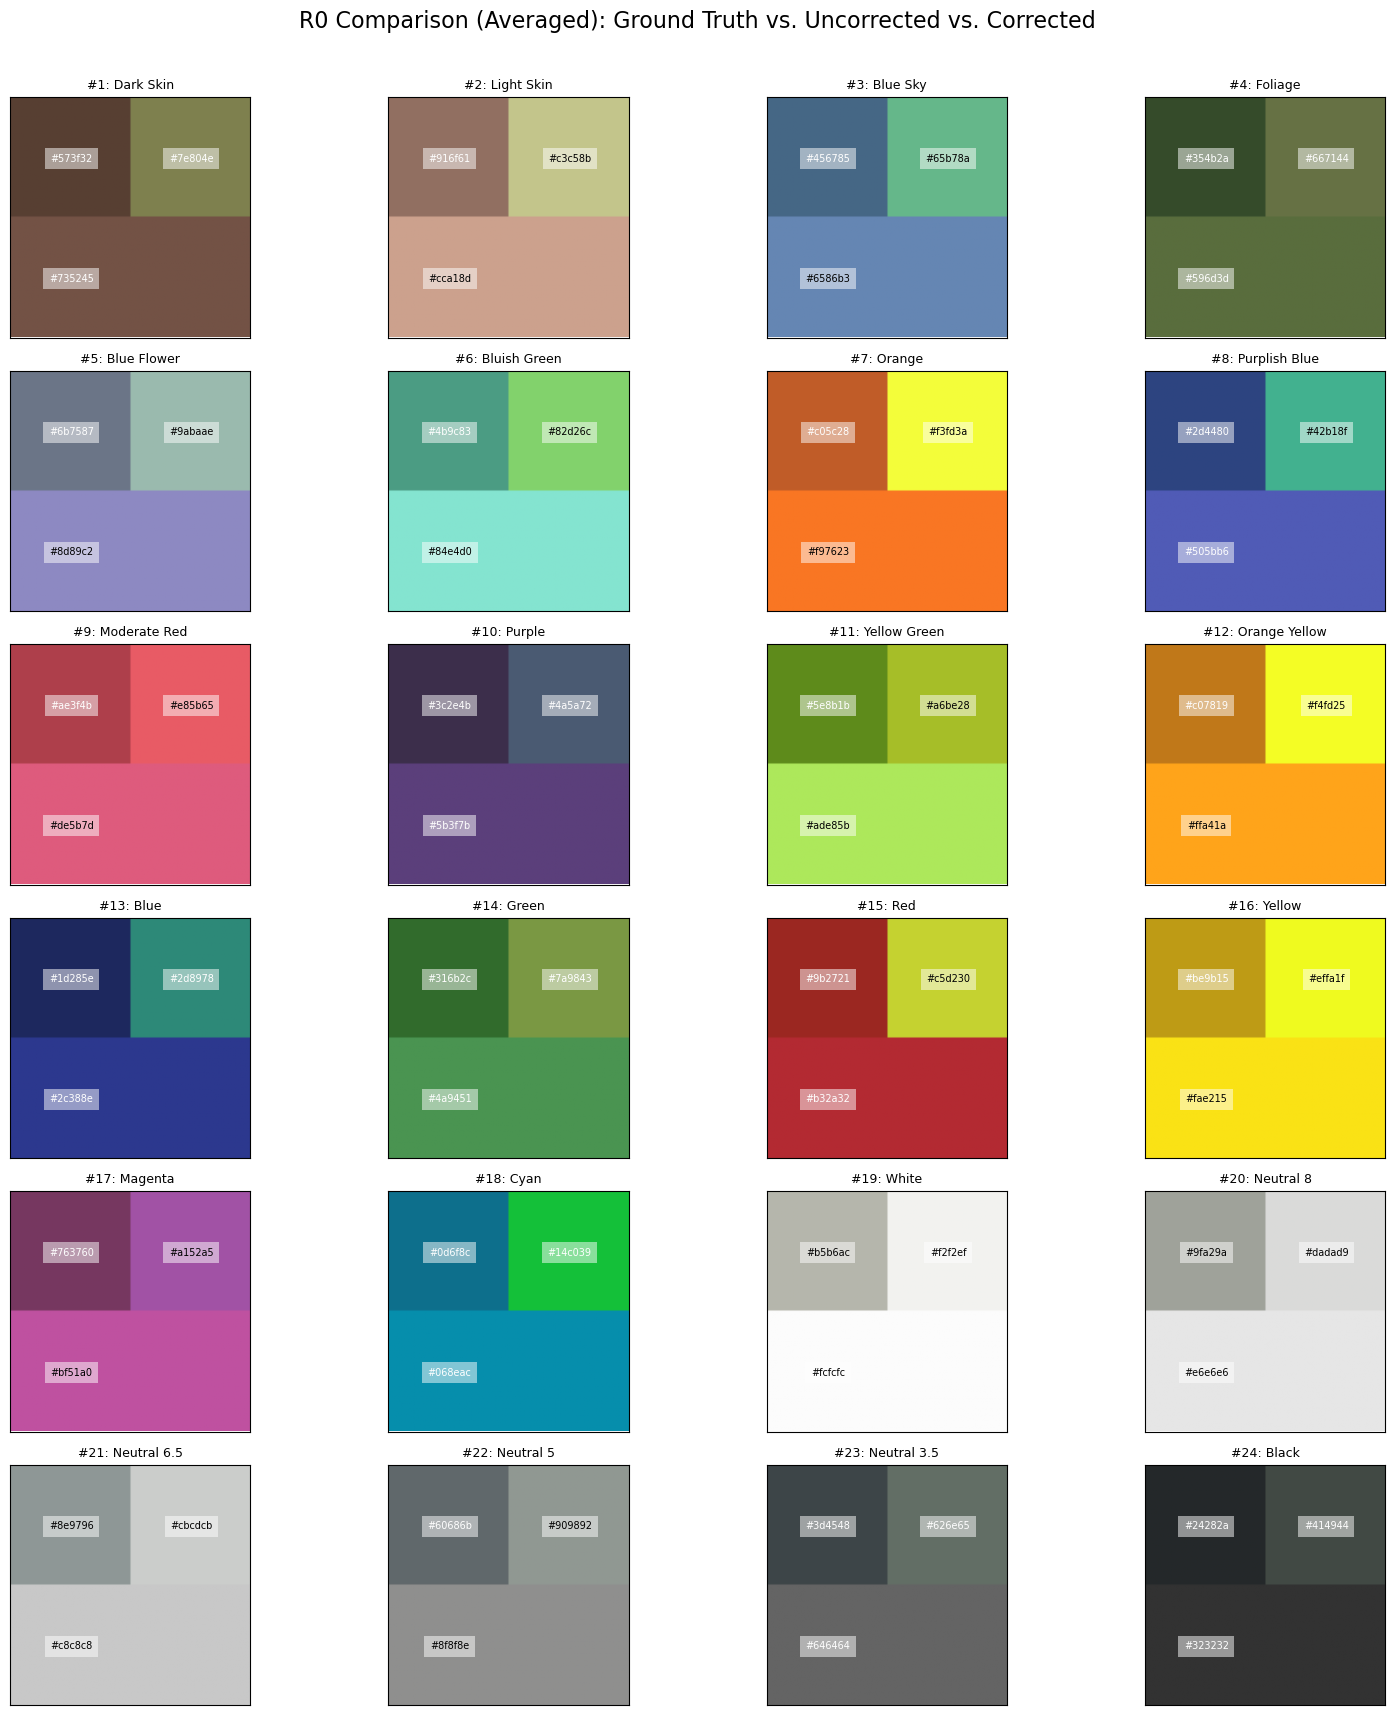

Plotting 24 unique samples for radius r2.


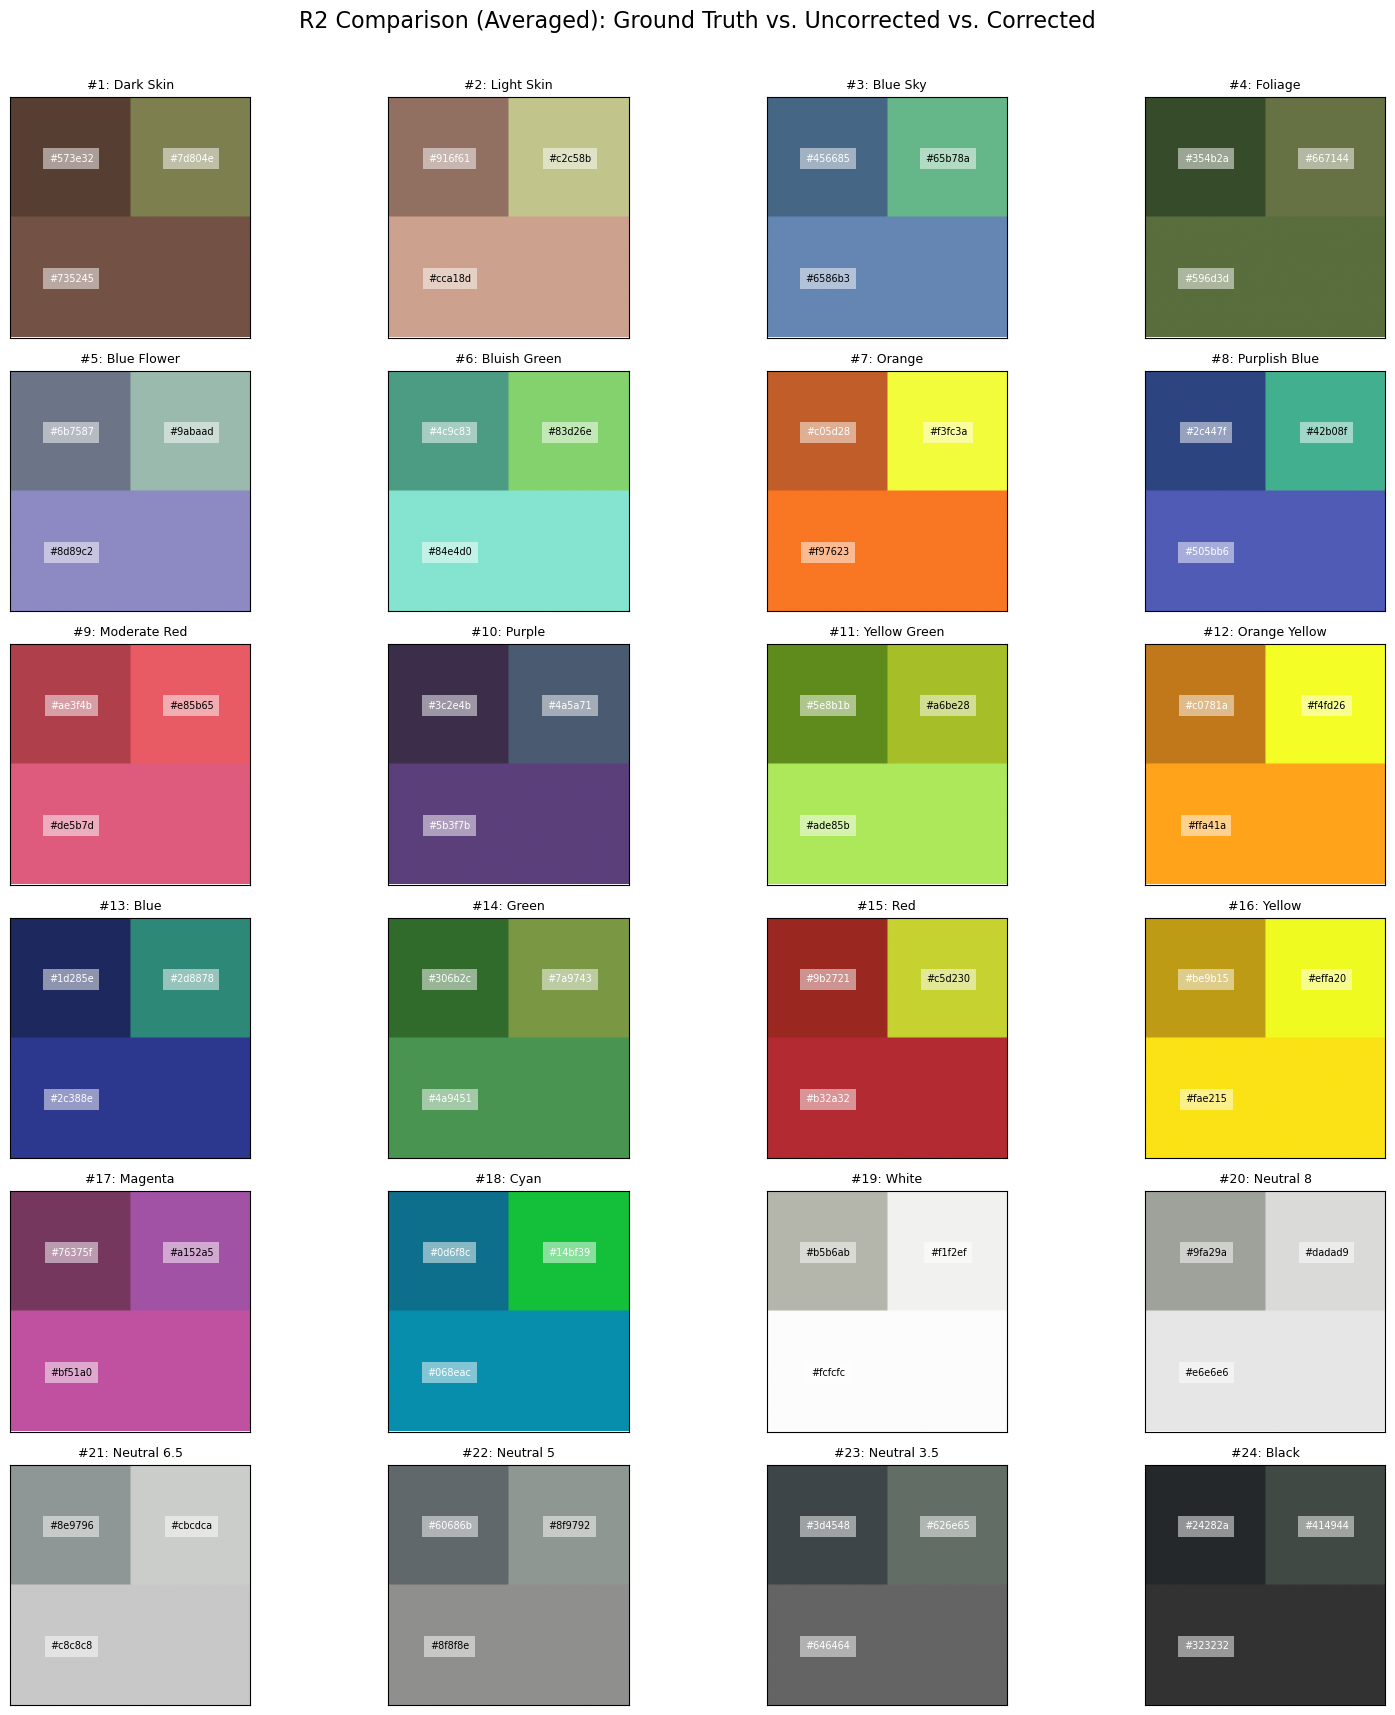

Plotting 24 unique samples for radius r4.


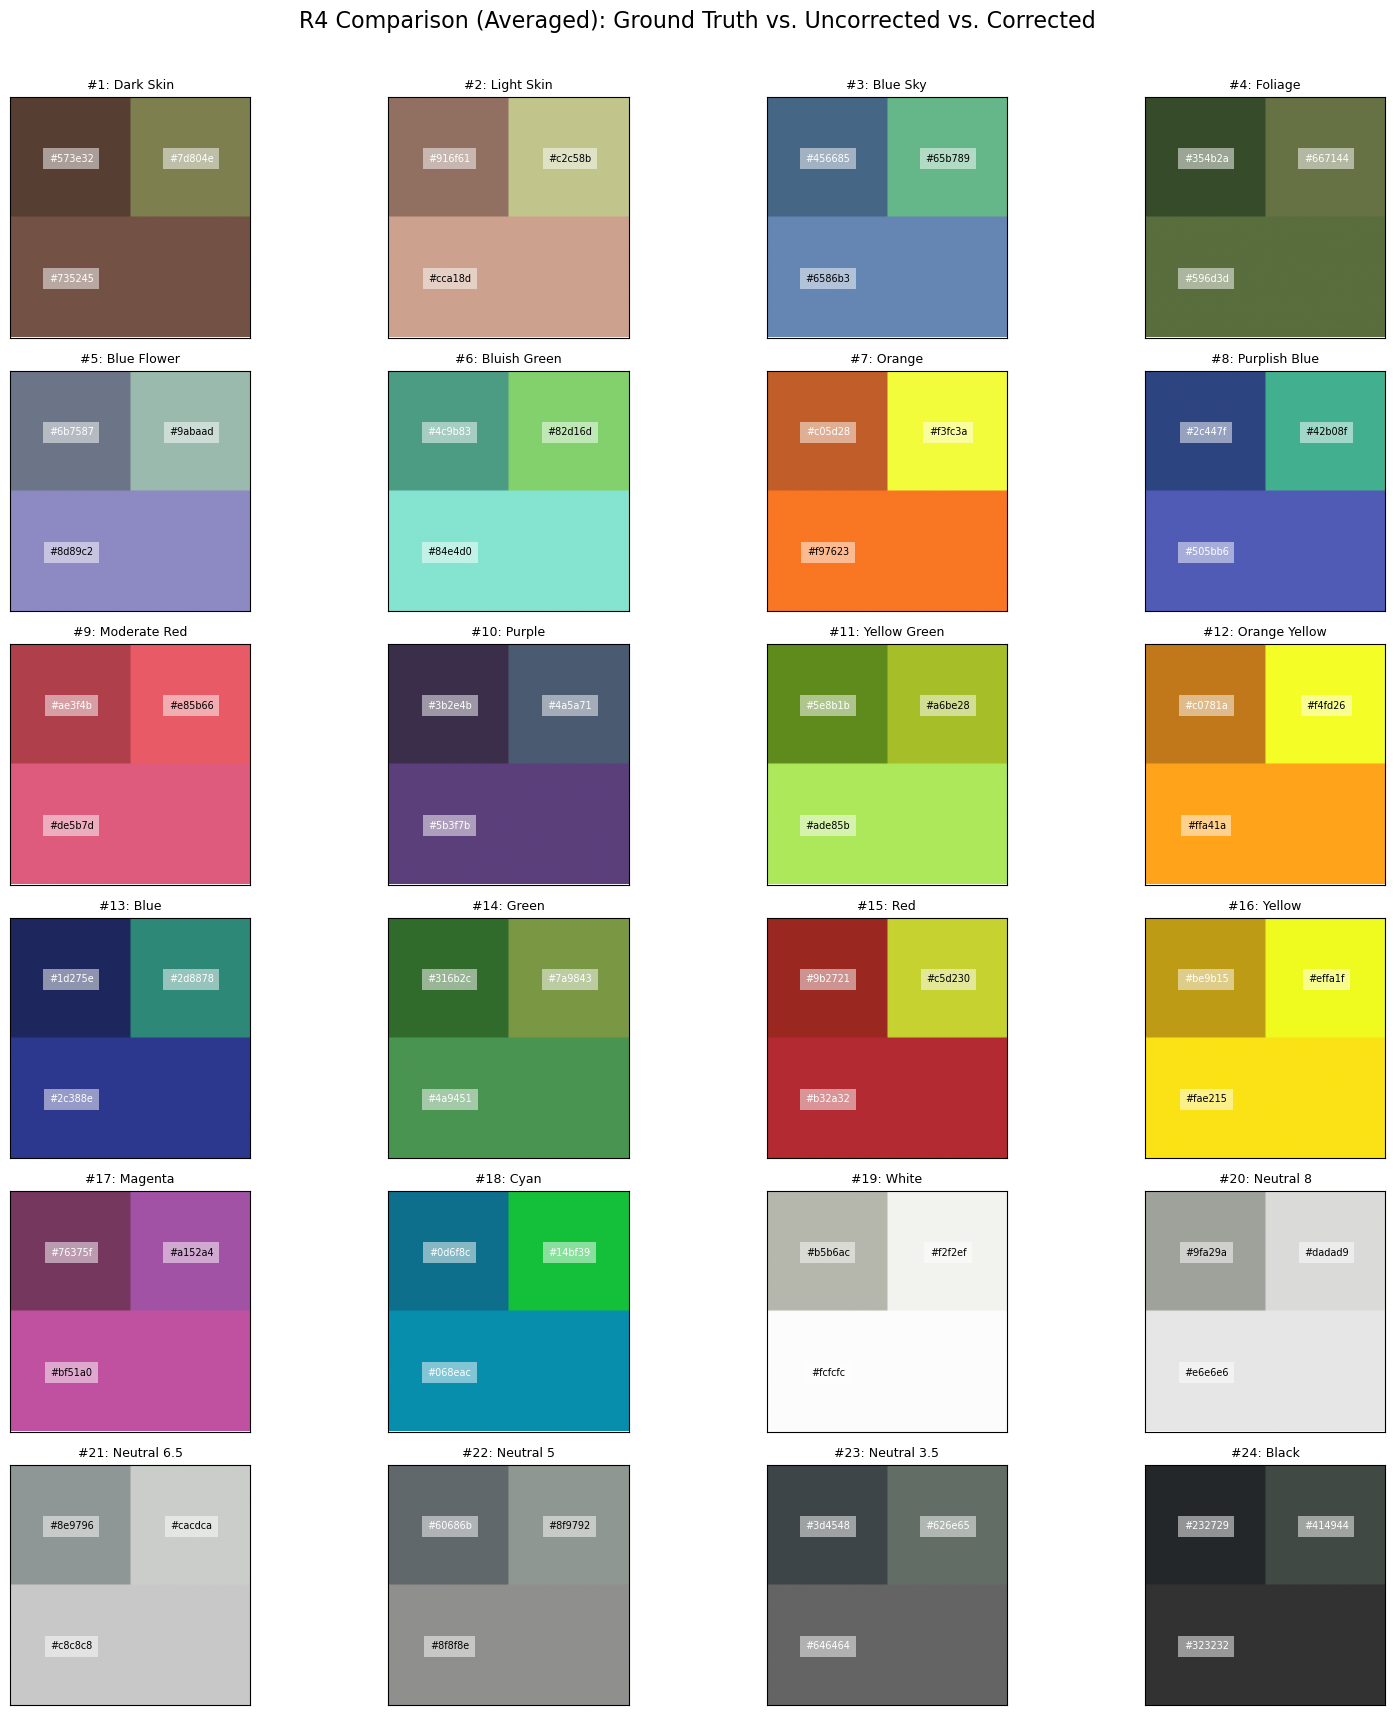

In [149]:
plotAllRadius(df_final_comparison)
# Not visually clear for human's eyes. But the MSE has decreased. A meticulous analysis would yield this is better.

In [150]:
def convert_rgb_to_hsv(r, g, b):
    # Normalize RGB values to 0-1 range
    normalized_rgb = np.array([r, g, b]) / 255.0
    # Convert to HSV
    hsv = rgb_to_hsv(normalized_rgb)
    return hsv[0], hsv[1], hsv[2]

# Apply to Ground Truth colors
def df_HSV(df_final_comparison):
  df_final_comparison[['gt__H', 'gt__S', 'gt__V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['gt__R'], row['gt__G'], row['gt__B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Uncorrected colors
  df_final_comparison[['uncorr_H', 'uncorr_S', 'uncorr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['color_r2_R'], row['color_r2_G'], row['color_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Apply to Corrected colors
  df_final_comparison[['corr_H', 'corr_S', 'corr_V']] = df_final_comparison.apply(
      lambda row: convert_rgb_to_hsv(row['correction_r2_R'], row['correction_r2_G'], row['correction_r2_B']),
      axis=1,
      result_type='expand'
  )

  # Calculate H_error considering the circular nature of Hue (normalized to 0-1)
  h_diff_uncorr = np.abs(df_final_comparison['uncorr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_uncorr'] = np.minimum(h_diff_uncorr, 1 - h_diff_uncorr)

  h_diff_corr = np.abs(df_final_comparison['corr_H'] - df_final_comparison['gt__H'])
  df_final_comparison['H_error_corr'] = np.minimum(h_diff_corr, 1 - h_diff_corr)

  df_final_comparison['S_error_uncorr'] = df_final_comparison['uncorr_S'] - df_final_comparison['gt__S']
  df_final_comparison['S_error_corr'] = df_final_comparison['corr_S'] - df_final_comparison['gt__S']

  df_final_comparison['V_error_uncorr'] = df_final_comparison['uncorr_V'] - df_final_comparison['gt__V']
  df_final_comparison['V_error_corr'] = df_final_comparison['corr_V'] - df_final_comparison['gt__V']
  return df_final_comparison

In [151]:
# Define the HSV components to plot
def plotHSV(df_final_comparison):
  hsv_components = ['H', 'S', 'V']

  for component in hsv_components:
      plt.figure(figsize=(10, 6))

      # Uncorrected error column name
      uncorr_error_col = f'{component}_error_uncorr'
      # Corrected error column name
      corr_error_col = f'{component}_error_corr'

      # Plot uncorrected error distribution
      sns.kdeplot(x=df_final_comparison[uncorr_error_col],
              fill=True,
              color='blue',
              label='Uncorrected',
              alpha=0.2,
              common_norm=False)

      # Plot corrected error distribution
      #sns.histplot(df_final_comparison[corr_error_col], kde=True, color='red', label='Corrected', alpha=0.6, stat='density', common_norm=False)

      sns.kdeplot(x=df_final_comparison[corr_error_col],
              fill=True,
              color='red',
              label='Corrected',
              alpha=0.2,
              common_norm=False)

      # Calculate mean and standard deviation for both distributions
      mean_uncorr = df_final_comparison[uncorr_error_col].mean()
      std_uncorr = df_final_comparison[uncorr_error_col].std()

      mean_corr = df_final_comparison[corr_error_col].mean()
      std_corr = df_final_comparison[corr_error_col].std()

      # Add text annotations for mean and std dev
      plt.axvline(mean_uncorr, color='blue', linestyle='dashed', linewidth=1)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.9, f'Mean Uncorr: {mean_uncorr:.3f}', color='blue', fontsize=10)
      plt.text(mean_uncorr + 0.01, plt.ylim()[1]*0.85, f'Std Uncorr: {std_uncorr:.3f}', color='blue', fontsize=10)

      plt.axvline(mean_corr, color='red', linestyle='dashed', linewidth=1)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.75, f'Mean Corr: {mean_corr:.3f}', color='red', fontsize=10)
      plt.text(mean_corr + 0.01, plt.ylim()[1]*0.7, f'Std Corr: {std_corr:.3f}', color='red', fontsize=10)

      # Set title and labels
      plt.title(f'Distribution of {component} Error: Uncorrected vs. Corrected')
      plt.xlabel('Error Value')
      plt.ylabel('Density')
      plt.legend()
      plt.grid(True, linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


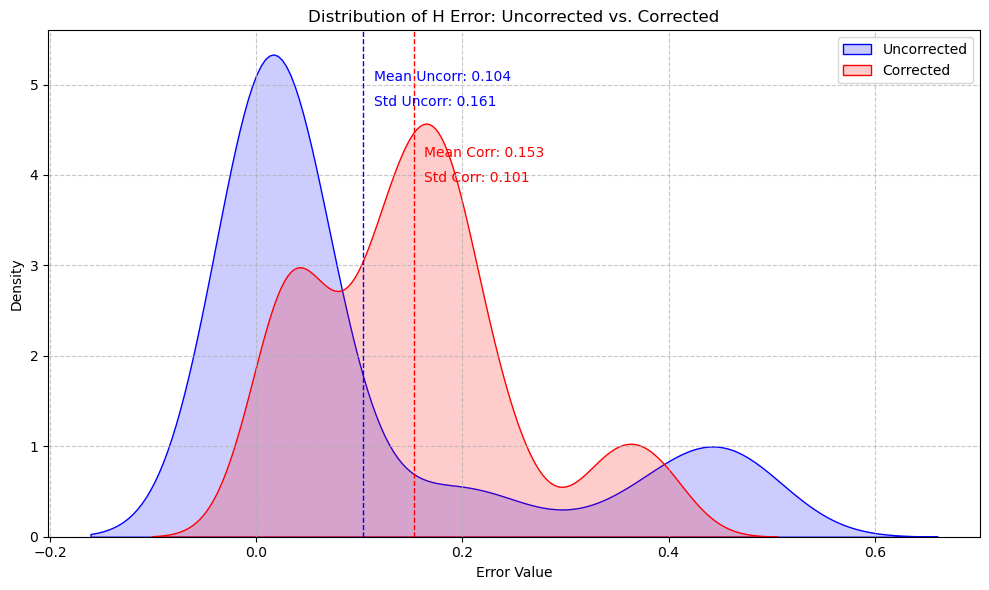

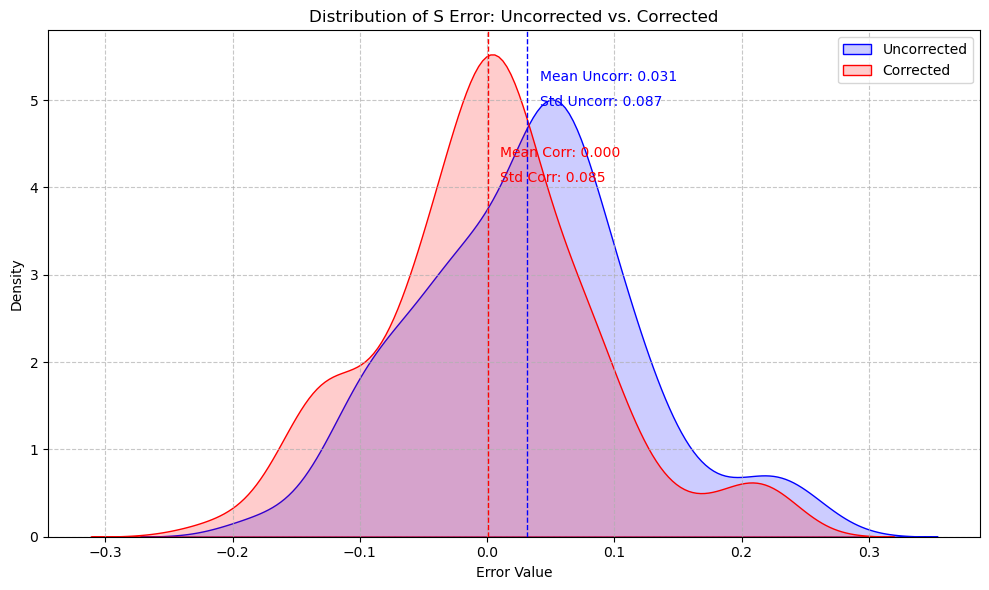

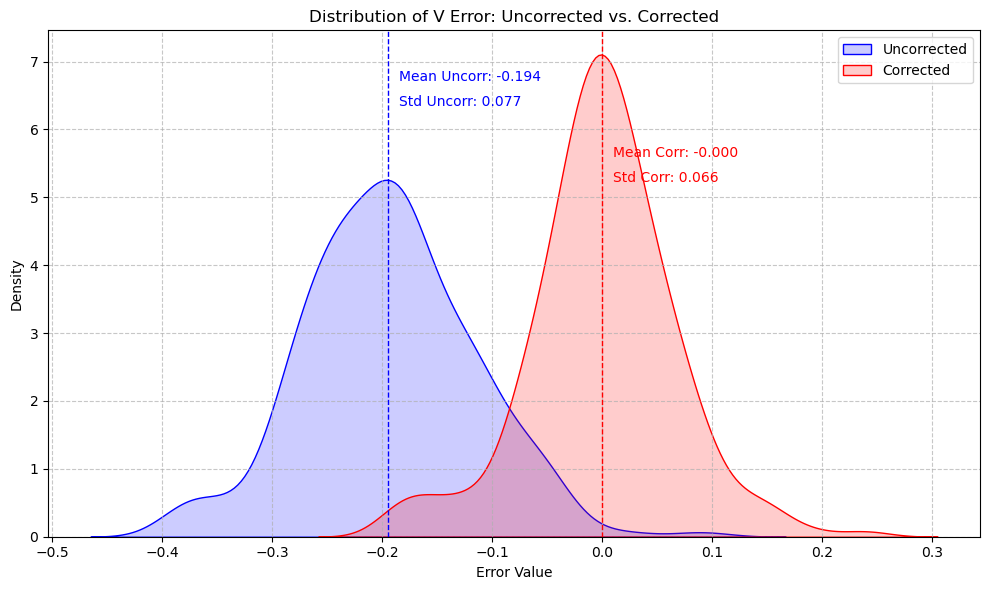

In [152]:
df = df_HSV(df)
plotHSV(df)

In [153]:
# Calculate MSE for each channel
mse_r_polynomial = mean_squared_error(df['gt__R'].values, df["correction_r4_R"].values)
mse_g_polynomial = mean_squared_error(df['gt__G'].values, df["correction_r4_G"].values)
mse_b_polynomial = mean_squared_error(df['gt__B'].values, df["correction_r4_B"].values)

# Calculate average MSE
avg_mse_polynomial = (mse_r_polynomial + mse_g_polynomial + mse_b_polynomial) / 3

ref_h = 0.11096491
ref_s = 0.20596206
ref_v = 0.72352941

# Apply the correction to the color_r4 values
corrected_h_white_scaling, corrected_s_white_scaling, corrected_v_white_scaling = correctByFixedWhiteScaling(
    ref_h, ref_s, ref_v,
    df['color_r4_H'].values,
    df['color_r4_S'].values,
    df['color_r4_V'].values
)

hsv = np.stack(
    [corrected_h_white_scaling,
     corrected_s_white_scaling,
     corrected_v_white_scaling],
    axis=1
)

rgb = hsv_to_rgb(hsv)

corrected_r_white_scaling = rgb[:, 0] * 255
corrected_g_white_scaling = rgb[:, 1] * 255
corrected_b_white_scaling = rgb[:, 2] * 255
# Calculate MSE for each channel
mse_r_white_scaling = mean_squared_error(df['gt__R'].values, corrected_r_white_scaling)
mse_g_white_scaling = mean_squared_error(df['gt__G'].values, corrected_g_white_scaling)
mse_b_white_scaling = mean_squared_error(df['gt__B'].values, corrected_b_white_scaling)

# Calculate average MSE
avg_mse_white_scaling = (mse_r_white_scaling + mse_g_white_scaling + mse_b_white_scaling) / 3

print("Fixed White Scaling MSE:")
print(f"  R Channel MSE: {mse_r_white_scaling:.2f}")
print(f"  G Channel MSE: {mse_g_white_scaling:.2f}")
print(f"  B Channel MSE: {mse_b_white_scaling:.2f}")
print(f"  Average MSE: {avg_mse_white_scaling:.2f}")


print("\nIndividually Optimized Polynomial Correction MSE:")
print(f"  R Channel MSE: {mse_r_polynomial:.2f}")
print(f"  G Channel MSE: {mse_g_polynomial:.2f}")
print(f"  B Channel MSE: {mse_b_polynomial:.2f}")
print(f"  Average MSE: {avg_mse_polynomial:.2f}")

Fixed White Scaling MSE:
  R Channel MSE: 3582.93
  G Channel MSE: 1936.57
  B Channel MSE: 3137.57
  Average MSE: 2885.69

Individually Optimized Polynomial Correction MSE:
  R Channel MSE: 299.03
  G Channel MSE: 3525.95
  B Channel MSE: 1418.62
  Average MSE: 1747.87


## Method 2: Using Matrix Correction:  
## [correction_r2_H    correction_r2_S   correction_r2_V]^T
## = [3 x 3 matrix] * [color_r2_H   color_r2_S   color_r2_V]^T
## Our task: Learn 9 entries of the 3 x 3 matrix.
## Conclusion: Compare with Fixed Scaling Method

In [154]:
def _apply_matrix_transform(h, s, v, matrix):
    """
    Applies a 3x3 transformation matrix to RGB values without clipping.
    h, s, v can be scalars or NumPy arrays.
    """
    # Ensure h, s, v are numpy arrays for consistent matrix multiplication
    h_arr = np.atleast_1d(h)
    s_arr = np.atleast_1d(s)
    v_arr = np.atleast_1d(v)

    # Stack HSV into a 3xN array (or 3x1 if scalars)
    hsv_stacked = np.vstack([h_arr, s_arr, v_arr])

    # Perform matrix multiplication
    corrected_rgb_stacked = np.dot(matrix, hsv_stacked)

    # Return corrected R, G, B as separate arrays (or scalars if original inputs were)
    if h_arr.ndim == 0:
        return corrected_rgb_stacked[0][0], corrected_rgb_stacked[1][0], corrected_rgb_stacked[2][0]
    return corrected_rgb_stacked[0], corrected_rgb_stacked[1], corrected_rgb_stacked[2]

def correctByMatrix(h, s, v, matrix):
    """
    Applies a 3x3 transformation matrix to HSV values and clips the results to [0, 255].
    h, s, v can be scalars or NumPy arrays.
    """
    corr_h, corr_s, corr_v = _apply_matrix_transform(h, s, v, matrix)
    corr_h_clipped = corr_h % 1.0  # Hue wraps around
    # Clip the resulting corrected S, V values to the range [0, 1]
    corr_s_clipped = np.clip(corr_s, 0, 1)
    corr_v_clipped = np.clip(corr_v, 0, 1)

    return corr_h_clipped, corr_s_clipped, corr_v_clipped
def calculateMatrixLoss(flat_matrix_elements, measured_h, measured_s, measured_v, gt_h, gt_s, gt_v):
    """
    Loss function for optimizing a 3x3 transformation matrix.
    """
    matrix = flat_matrix_elements.reshape(3, 3)
    corr_h_unclipped, corr_s_unclipped, corr_v_unclipped = _apply_matrix_transform(
        measured_h, measured_s, measured_v, matrix
    )

    # Calculate the Mean Squared Error (MSE) for each channel
    mse_h = mean_squared_error(gt_h, corr_h_unclipped)
    mse_s = mean_squared_error(gt_s, corr_s_unclipped)
    mse_v = mean_squared_error(gt_v, corr_v_unclipped)

    # Average MSE across channels
    total_mse = (mse_h + mse_s + mse_v) / 3.0

    # Add a boundary_penalty that penalizes values outside the [0, 1] range
    boundary_penalty_s = np.mean((corr_s_unclipped < 0) | (corr_s_unclipped > 1)) * 1000
    boundary_penalty_v = np.mean((corr_v_unclipped < 0) | (corr_v_unclipped > 1)) * 1000
    boundary_penalty = boundary_penalty_s + boundary_penalty_v

    # Add a reg_penalty to penalize large matrix coefficients
    reg_penalty = 0.001 * np.sum(flat_matrix_elements**2)

    # Return the sum of the MSE (average across channels), boundary penalty, and regularization penalty.
    return total_mse + boundary_penalty + reg_penalty

def get_identity_matrix_flat():
    """
    Returns a 1D NumPy array representing a flattened 3x3 identity matrix.
    This will serve as an initial guess for the optimization.
    """
    return np.identity(3).flatten()

print("Matrix correction and optimization functions defined.")

Matrix correction and optimization functions defined.


In [155]:
measured_h = df['color_r4_H'].values
measured_s = df['color_r4_S'].values
measured_v = df['color_r4_V'].values

gt_h = df['gt__H'].values
gt_s = df['gt__S'].values
gt_v = df['gt__V'].values

print("Extracted measured and ground truth HSV values.")

Extracted measured and ground truth HSV values.


In [156]:
initial_guess = get_identity_matrix_flat()
bounds = [(-5, 5)] * 9

# Use partial to pass fixed arguments to the loss function
loss_func_partial = partial(
    calculateMatrixLoss,
    measured_h=measured_h,
    measured_s=measured_s,
    measured_v=measured_v,
    gt_h=gt_h,
    gt_s=gt_s,
    gt_v=gt_v
)

# Optimize using scipy.optimize.minimize
print("Optimizing 3x3 matrix...")
result = minimize(
    loss_func_partial,
    initial_guess,
    method='L-BFGS-B', # L-BFGS-B supports bounds
    bounds=bounds,
    options={'maxiter': 1000, 'ftol': 1e-8}
)

# Reshape the optimized 1D array of coefficients back into a 3x3 NumPy array
optimal_matrix = result.x.reshape(3, 3)

print("\nOptimization complete.")
print("Optimal 3x3 Transformation Matrix:")
print(optimal_matrix)

Optimizing 3x3 matrix...

Optimization complete.
Optimal 3x3 Transformation Matrix:
[[ 0.88061677  0.08257894 -0.02161888]
 [-0.01841029  0.98337557 -0.01446451]
 [ 0.09611309  0.11505302  1.13898557]]


In [157]:
corrected_h_matrix, corrected_s_matrix, corrected_v_matrix = correctByMatrix(
    df['color_r4_H'].values,
    df['color_r4_S'].values,
    df['color_r4_V'].values,
    optimal_matrix
)
rgb = hsv_to_rgb(
    np.stack([corrected_h_matrix,
              corrected_s_matrix,
              corrected_v_matrix], axis=1)
)

rgb = np.clip(rgb * 255.0, 0, 255)

corrected_r_matrix = rgb[:, 0]
corrected_g_matrix = rgb[:, 1]
corrected_b_matrix = rgb[:, 2]

df['correction_r4_R_matrix'] = corrected_r_matrix
df['correction_r4_G_matrix'] = corrected_g_matrix
df['correction_r4_B_matrix'] = corrected_b_matrix

print("Applied matrix correction and stored results in new columns.")



Applied matrix correction and stored results in new columns.


In [158]:
mse_r_matrix_correction = mean_squared_error(df['gt__R'].values, df['correction_r4_R_matrix'].values)
mse_g_matrix_correction = mean_squared_error(df['gt__G'].values, df['correction_r4_G_matrix'].values)
mse_b_matrix_correction = mean_squared_error(df['gt__B'].values, df['correction_r4_B_matrix'].values)

avg_mse_matrix_correction = (mse_r_matrix_correction + mse_g_matrix_correction + mse_b_matrix_correction) / 3
print("\n--- Comparative Summary of Correction Methods ---")

print("\n1. Fixed White Scaling:")
print(f"  R Channel MSE: {mse_r_white_scaling:.2f}")
print(f"  G Channel MSE: {mse_g_white_scaling:.2f}")
print(f"  B Channel MSE: {mse_b_white_scaling:.2f}")
print(f"  Average MSE: {avg_mse_white_scaling:.2f}")

print("\n2. Individually Optimized Polynomial Correction:")
print(f"  R Channel MSE: {mse_r_polynomial:.2f}")
print(f"  G Channel MSE: {mse_g_polynomial:.2f}")
print(f"  B Channel MSE: {mse_b_polynomial:.2f}")
print(f"  Average MSE: {avg_mse_polynomial:.2f}")

print("\n3. Matrix Correction:")
print(f"  R Channel MSE: {mse_r_matrix_correction:.2f}")
print(f"  G Channel MSE: {mse_g_matrix_correction:.2f}")
print(f"  B Channel MSE: {mse_b_matrix_correction:.2f}")
print(f"  Average MSE: {avg_mse_matrix_correction:.2f}")


--- Comparative Summary of Correction Methods ---

1. Fixed White Scaling:
  R Channel MSE: 3582.93
  G Channel MSE: 1936.57
  B Channel MSE: 3137.57
  Average MSE: 2885.69

2. Individually Optimized Polynomial Correction:
  R Channel MSE: 299.03
  G Channel MSE: 3525.95
  B Channel MSE: 1418.62
  Average MSE: 1747.87

3. Matrix Correction:
  R Channel MSE: 586.97
  G Channel MSE: 825.11
  B Channel MSE: 718.15
  Average MSE: 710.08


## Method 3: Using Multiple Input: correction_r2 = f(color_r2, pitch, roll)
## Our task: Learn the coefficient of f (linear for now).
## Conclusion: Compare with Fixed Scaling Method

In [159]:
def correctByMultiInputModel(measured_h, measured_s, measured_v, pitch, roll, coeffs):
  # Ensure all inputs are NumPy arrays
  measured_h = np.asarray(measured_h)
  measured_s = np.asarray(measured_s)
  measured_v = np.asarray(measured_v)
  pitch = np.asarray(pitch)
  roll = np.asarray(roll)
  coeffs = np.asarray(coeffs)

  # Each row corresponds to an output channel (R, G, B)
  # Each column corresponds to an input feature: [intercept, R_in, G_in, B_in, Pitch, Roll]
  coeffs_matrix = coeffs.reshape(3, 6)

  # Create an input_features matrix (N x 6)
  # Columns: [1, measured_h, measured_s, measured_v, pitch, roll]
  input_features = np.vstack([
      np.ones_like(measured_h), # Intercept term
      measured_h,
      measured_s,
      measured_v,
      pitch,
      roll
  ]).T # Transpose to get N rows x 6 features

  # Perform matrix multiplication to calculate corrected HSV values
  # coeffs_matrix (3x6) @ input_features.T (6xN) = corrected_hsv_unclipped (3xN)
  corrected_hsv_unclipped = coeffs_matrix @ input_features.T

  # Extract corrected H, S, V arrays
  corrected_h_unclipped = corrected_hsv_unclipped[0]
  corrected_s_unclipped = corrected_hsv_unclipped[1]
  corrected_v_unclipped = corrected_hsv_unclipped[2]

  # Clip the corrected values to the range [0, 1] and convert to integer
  corrected_h_clipped = corrected_h_unclipped % 1.0  # Hue wraps around
  corrected_s_clipped = np.clip(corrected_s_unclipped, 0, 1)
  corrected_v_clipped = np.clip(corrected_v_unclipped, 0, 1)

  return corrected_h_clipped, corrected_s_clipped, corrected_v_clipped

print("correctByMultiInputModel function defined.")

correctByMultiInputModel function defined.


In [160]:
measured_h_multi = df['color_r4_H'].values
measured_s_multi = df['color_r4_S'].values
measured_v_multi = df['color_r4_V'].values

pitch_multi = df['pitch'].values
roll_multi = df['roll'].values

gt_h_multi = df['gt__H'].values
gt_s_multi = df['gt__S'].values
gt_v_multi = df['gt__V'].values

print("Extracted measured HSV, sensor data (pitch, roll), and ground truth HSV values for multi-input model.")

Extracted measured HSV, sensor data (pitch, roll), and ground truth HSV values for multi-input model.


In [161]:
def _apply_multi_input_model_unclipped(measured_h, measured_s, measured_v, pitch, roll, coeffs):
    # Ensure all inputs are NumPy arrays
    measured_h = np.asarray(measured_h)
    measured_s = np.asarray(measured_s)
    measured_v = np.asarray(measured_v)
    pitch = np.asarray(pitch)
    roll = np.asarray(roll)
    coeffs = np.asarray(coeffs)

    # Reshape the 1D coeffs array into a 3x6 matrix
    coeffs_matrix = coeffs.reshape(3, 6)

    # Create an input_features matrix (N x 6)
    input_features = np.vstack([
        np.ones_like(measured_h), # Intercept term
        measured_h,
        measured_s,
        measured_v,
        pitch,
        roll
    ]).T # Transpose to get N rows x 6 features

    # Perform matrix multiplication to calculate corrected HSV values
    corrected_hsv_unclipped = coeffs_matrix @ input_features.T

    # Extract corrected H, S, V arrays
    corrected_h_unclipped = corrected_hsv_unclipped[0]
    corrected_s_unclipped = corrected_hsv_unclipped[1]
    corrected_v_unclipped = corrected_hsv_unclipped[2]

    return corrected_h_unclipped, corrected_s_unclipped, corrected_v_unclipped

def calculateMultiInputLoss(flat_coeffs, measured_h, measured_s, measured_v, pitch, roll, gt_h, gt_s, gt_v):
    # Use the unclipped version of the model for loss calculation
    corr_h_unclipped, corr_s_unclipped, corr_v_unclipped = _apply_multi_input_model_unclipped(
        measured_h, measured_s, measured_v, pitch, roll, flat_coeffs
    )

    # Calculate MSE for each channel
    mse_h = mean_squared_error(gt_h, corr_h_unclipped)
    mse_s = mean_squared_error(gt_s, corr_s_unclipped)
    mse_v = mean_squared_error(gt_v, corr_v_unclipped)

    # Average MSE across channels
    total_mse = (mse_h + mse_s + mse_v) / 3.0
    # Implement boundary penalty
    # Penalize values outside [0, 255] range
    boundary_penalty = (
        np.mean((corr_s_unclipped < 0) | (corr_s_unclipped > 1)) +
        np.mean((corr_v_unclipped < 0) | (corr_v_unclipped > 1))
    ) * 1000 # Scaling factor for boundary penalty

    # Implement regularization penalty (L2 regularization on coefficients)
    reg_penalty = 0.001 * np.sum(flat_coeffs**2)

    # Return the total loss
    return total_mse + boundary_penalty + reg_penalty

print("`_apply_multi_input_model_unclipped` and `calculateMultiInputLoss` functions defined.")

`_apply_multi_input_model_unclipped` and `calculateMultiInputLoss` functions defined.


In [162]:
import numpy as np
from scipy.optimize import minimize
from functools import partial

initial_guess = np.array([
    0, 1, 0, 0, 0, 0,
    0, 0, 1, 0, 0, 0,
    0, 0, 0, 1, 0, 0
], dtype=float)

# 2. Define bounds for the 18 coefficients
bounds = [(-5.0, 5.0)] * 18

# 3. Create a partial function for calculateMultiInputLoss
loss_func_partial_multi_input = partial(
    calculateMultiInputLoss,
    measured_h=measured_h_multi,
    measured_s=measured_s_multi,
    measured_v=measured_v_multi,
    pitch=pitch_multi,
    roll=roll_multi,
    gt_h=gt_h_multi,
    gt_s=gt_s_multi,
    gt_v=gt_v_multi
)

# 4. Use scipy.optimize.minimize
print("Optimizing multi-input model coefficients...")
result_multi_input = minimize(
    loss_func_partial_multi_input,
    initial_guess,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1000, 'ftol': 1e-8}
)

# 5. Reshape the optimized 1D array of coefficients back into a 3x6 matrix
optimal_multi_input_coeffs = result_multi_input.x.reshape(3, 6)

# 6. Print the optimal_multi_input_coeffs matrix
print("\nOptimization complete.")
print("Optimal Multi-Input Model Coefficients (3x6 matrix):")
print(optimal_multi_input_coeffs)


Optimizing multi-input model coefficients...

Optimization complete.
Optimal Multi-Input Model Coefficients (3x6 matrix):
[[-3.34719423e-04  9.99690748e-01  1.63981968e-04 -7.23359507e-05
  -5.45360273e-04 -7.74760175e-04]
 [-2.25560300e-04 -9.03854712e-05  9.99904616e-01 -9.32171012e-05
   1.16572636e-03 -4.00548675e-04]
 [ 1.23386053e-03  4.95790727e-04  6.18598547e-04  1.00065904e+00
   2.36003046e-03  1.58966046e-03]]


In [163]:
corrected_h_multi, corrected_s_multi, corrected_v_multi = correctByMultiInputModel(
    measured_h_multi,
    measured_s_multi,
    measured_v_multi,
    pitch_multi,
    roll_multi,
    optimal_multi_input_coeffs.flatten() # Flatten the 3x6 matrix back to 1D for the function
)

rgb = hsv_to_rgb(
    np.stack([corrected_h_multi,
              corrected_s_multi,
              corrected_v_multi], axis=1)
)

rgb = np.clip(rgb * 255.0, 0, 255)

corrected_r_multi = rgb[:, 0]
corrected_g_multi = rgb[:, 1]
corrected_b_multi = rgb[:, 2]

df['correction_r4_R_multi'] = corrected_r_multi
df['correction_r4_G_multi'] = corrected_g_multi
df['correction_r4_B_multi'] = corrected_b_multi

print("Applied multi-input model correction and stored results in new columns: 'correction_r4_R_multi', 'correction_r4_G_multi', 'correction_r4_B_multi'.")

Applied multi-input model correction and stored results in new columns: 'correction_r4_R_multi', 'correction_r4_G_multi', 'correction_r4_B_multi'.


In [164]:
mse_r_multi_input = mean_squared_error(df['gt__R'].values, df['correction_r4_R_multi'].values)
mse_g_multi_input = mean_squared_error(df['gt__G'].values, df['correction_r4_G_multi'].values)
mse_b_multi_input = mean_squared_error(df['gt__B'].values, df['correction_r4_B_multi'].values)

avg_mse_multi_input = (mse_r_multi_input + mse_g_multi_input + mse_b_multi_input) / 3

print("\nMulti-Input Correction MSE:")
print(f"  R Channel MSE: {mse_r_multi_input:.2f}")
print(f"  G Channel MSE: {mse_g_multi_input:.2f}")
print(f"  B Channel MSE: {mse_b_multi_input:.2f}")
print(f"  Average MSE: {avg_mse_multi_input:.2f}")

print("\n--- Comparative Summary of All Correction Methods ---")

print("\n1. Fixed White Scaling:")
print(f"  R Channel MSE: {mse_r_white_scaling:.2f}")
print(f"  G Channel MSE: {mse_g_white_scaling:.2f}")
print(f"  B Channel MSE: {mse_b_white_scaling:.2f}")
print(f"  Average MSE: {avg_mse_white_scaling:.2f}")

print("\n2. Individually Optimized Polynomial Correction:")
print(f"  R Channel MSE: {mse_r_polynomial:.2f}")
print(f"  G Channel MSE: {mse_g_polynomial:.2f}")
print(f"  B Channel MSE: {mse_b_polynomial:.2f}")
print(f"  Average MSE: {avg_mse_polynomial:.2f}")

print("\n3. Matrix Correction:")
print(f"  R Channel MSE: {mse_r_matrix_correction:.2f}")
print(f"  G Channel MSE: {mse_g_matrix_correction:.2f}")
print(f"  B Channel MSE: {mse_b_matrix_correction:.2f}")
print(f"  Average MSE: {avg_mse_matrix_correction:.2f}")

print("\n4. Multi-Input Correction:")
print(f"  R Channel MSE: {mse_r_multi_input:.2f}")
print(f"  G Channel MSE: {mse_g_multi_input:.2f}")
print(f"  B Channel MSE: {mse_b_multi_input:.2f}")
print(f"  Average MSE: {avg_mse_multi_input:.2f}")


Multi-Input Correction MSE:
  R Channel MSE: 2177.19
  G Channel MSE: 1893.27
  B Channel MSE: 2031.92
  Average MSE: 2034.12

--- Comparative Summary of All Correction Methods ---

1. Fixed White Scaling:
  R Channel MSE: 3582.93
  G Channel MSE: 1936.57
  B Channel MSE: 3137.57
  Average MSE: 2885.69

2. Individually Optimized Polynomial Correction:
  R Channel MSE: 299.03
  G Channel MSE: 3525.95
  B Channel MSE: 1418.62
  Average MSE: 1747.87

3. Matrix Correction:
  R Channel MSE: 586.97
  G Channel MSE: 825.11
  B Channel MSE: 718.15
  Average MSE: 710.08

4. Multi-Input Correction:
  R Channel MSE: 2177.19
  G Channel MSE: 1893.27
  B Channel MSE: 2031.92
  Average MSE: 2034.12


In [165]:
import numpy as np

def compute_mse(y_true, y_pred):
    """
    Compute Mean Squared Error (MSE).

    Parameters
    ----------
    y_true : array-like, shape (N,)
        Ground truth values
    y_pred : array-like, shape (N,)
        Predicted or measured values

    Returns
    -------
    mse : float
        Mean squared error
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    return np.mean((y_true - y_pred) ** 2)
mse_r = compute_mse(df['gt__R'], df['color_r2_R'])
mse_g = compute_mse(df['gt__G'], df['color_r2_G'])
mse_b = compute_mse(df['gt__B'], df['color_r2_B'])
msee = 0.0
count = 0
print("Measured vs Ground Truth MSE:")
print(f"  R Channel MSE: {mse_r:.2f}")
print(f"  G Channel MSE: {mse_g:.2f}")
print(f"  B Channel MSE: {mse_b:.2f}")
avg_mse = (mse_r + mse_g + mse_b) / 3.0

print(f"  Average RGB MSE: {avg_mse:.2f}")


Measured vs Ground Truth MSE:
  R Channel MSE: 2368.67
  G Channel MSE: 1947.56
  B Channel MSE: 2178.76
  Average RGB MSE: 2164.99
